# I. Introduction
In this tutorial, we will learn how to compute quasi-periodic orbits in the CR3BP.

Before we start, let's import the required packages.

In [1]:
@time using ThreeBodyProblem # CR3BP systems, equations of motion, plotting recipes, differential corrector
@time using OrdinaryDiffEq # For computing solutions to ODEs
@time using LinearAlgebra # For linear algebra computation
@time using Plots # import the Plots package

 11.430400 seconds (23.16 M allocations: 1.578 GiB, 6.40% gc time)
  0.000098 seconds (99 allocations: 7.672 KiB)
  0.000115 seconds (99 allocations: 7.672 KiB)
  0.000145 seconds (99 allocations: 7.672 KiB)


## I-i. What is a Quasi-Periodic Orbit (QPO)?
A quasi-periodic orbit (QPO) is a trajectory that exhibits bounded motion, but is not purely periodic. When we think of a purely periodic orbit, we imagine a closed curve in space. If we start at one point along the orbit, we'll return to that exact same point after one period. We saw that the orbit has one degree of freedom, how far along the period it is. 

A QPO has two degrees of freedom, meaning that the orbit looks like a closed surface rather than a curve. In this case, the surface is a torus and looks something like a donut. If we start at one point along the orbit, we'll never get back to the exact point again. The orbit rotates around the torus with two frequencies, one longitudinal, and one latitudinal. Let's plot a torus so we have a better picture in our mind's eye.

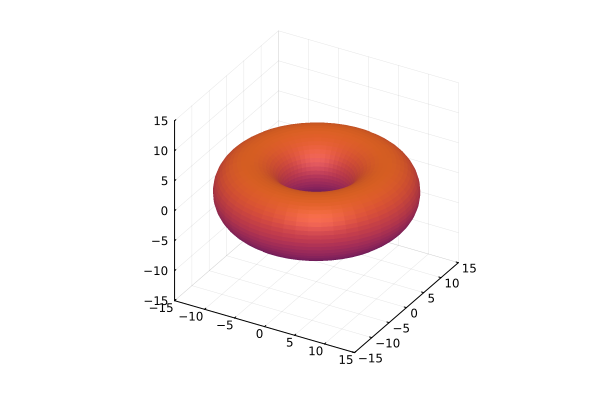

In [2]:
surface(torus(), lims=(-15,15), colorbar=false) # plot a torus

## I-ii. How can we compute a torus?
Those familiar with differential correction know how to use it to compute a periodic orbit. We start with an initial guess that almost returns to itself after one period T. We refer to the difference between the initial and final states as the error. For a perfectly periodic orbit, the initial state will return to itself exactly after one period, so the error is zero. We compute the Jacobian of the transformation from time 0 to T and use a pseudo-inverse to find the change in the initial conditions that will reduce the error. Iterating this process a few times normally leads to a very small error and our corrected state corresponds to a periodic orbit!

Since trajectories on a QPO never return to their initial state, we can't use the same method. But we can do something similar. Imagine taking a slice of the torus, which would look like a circle. Any trajectory that starts on that circle will return to the circle, just not at the exact same point. If we had a circle of points that returned to the same circle after one period, we would have a QPO! This is the central idea. Let's set up a system and see if we can apply the concept.

# II. Start with a Halo Orbit
We'll need to import a few packages to compute a halo orbit

## II-i. Define the system and initial conditions
We'll work in the Saturn/Enceladus system. We can find precomputed initial conditions for halo orbits at https://ssd.jpl.nasa.gov/tools/periodic_orbits.html

In [3]:
# Define the Saturn/Enceladus CR3BP system
sys = saturn_enceladus();

# Initial Conditions of the halo orbit (obtained from https://ssd.jpl.nasa.gov/tools/periodic_orbits.html)
rv₀ = [ 1.002850044069033
                        0
        0.004808592996246
       -0.000000000000001
       -0.005747591930694
       -0.000000000000006]

# Period of the halo orbit
T₀ = 2.445783783357601

2.445783783357601

## II-ii. Differential Correction
Let's run this initial condition through the differential corrector, just to make sure it's as accurate as possible

In [4]:
# Use the differential corrector to refine the initial conditions (our μ may be slightly different than that used on the website)
rv₀, T₀ = differential_corrector(sys, rv₀, tf=T₀) # differential_corrector() is a function of ThreeBodyProblem.jl

([1.0028493966190752, 0.0, 0.004808592996246, -1.0e-15, -0.005746919752084245, -6.0e-15], 2.4454220479887527)

In [5]:
# Jacobi constant of the halo orbit
C₀ = computeC(rv₀,sys)

3.0000356192421993

## II-iii. Integrate and plot
Now that we have our system and initial condition defined, we'll integrate the halo orbit and plot it

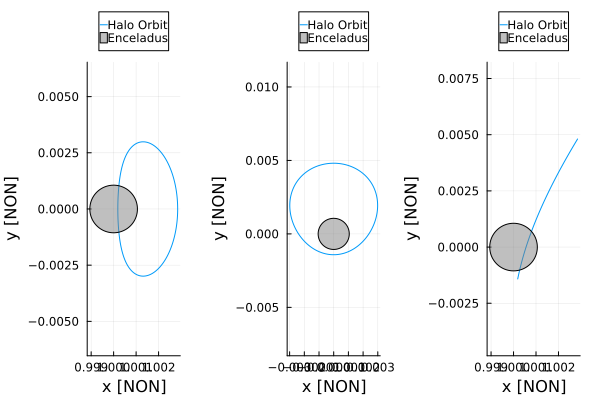

In [6]:
# We'll integrate the halo orbit and its state transition matrix (STM)
Φ₀ = I(6) # Initialization of the STM, Φ₀ = I
w₀ = [rv₀; reshape(Φ₀,36,1)] # Reshape the matrix into a vector and append it to the state vector
tspan = (0.,T₀) # integrate from 0 to T₀
prob_halo = ODEProblem(CR3BPstm!,w₀,tspan,sys) # CR3BPstm! is our in-place dynamics function for state and STM
halo = solve(prob_halo,TsitPap8(),abstol=1e-12,reltol=1e-12) # solve the problem

# Plot the halo orbit
pxy = plot(halo,idxs=(1,2),label="Halo Orbit",legend=false,xaxis="x",yaxis="y"); # plot the halo orbit in the x-y plane
plot!(sys,prim=false,Lpts=false, lims=:auto);

pyz = plot(halo,idxs=(2,3),label="Halo Orbit",legend=false,xaxis="y",yaxis="z"); # plot the halo orbit in the y-z plane
plot!(sys,prim=false,Lpts=false, lims=:auto, center=[0,0,0]);

pxz = plot(halo,idxs=(1,3),label="Halo Orbit", legend=false,xaxis="x",yaxis="z"); # plot the halo orbit in the x-z plane
plot!(sys,prim=false,Lpts=false, lims=:auto);

# pall = plot(halo,idxs=(1,2,3),legend=false,title="Halo Orbit",label="Halo Orbit"); # plot the halo orbit in 3D
# plot!(pall,sys,planar=false,prim=false,Lpts=false,lims=:auto);

plot_halo = plot(pxy,pyz,pxz,layout=(1,3),legend=:outertop) # plot all of the plots in a 2x2 grid
# plot_halo = plot(pxy,pyz,pxz,pall,layout=(1,4),title="Halo Orbit") # plot all of the plots in a 2x2 grid

# III. Approximate the Invariant Circle
OK, now we have the halo orbit and its state transition matrix (STM). We want to approximate a quasi-halo orbit around the halo orbit. A quasi-halo orbit lives on the surface of a torus, so it is a 2-dimensional object rather than a 1-dimensional curve like the halo orbit. It's tricky working with surfaces. For example, how do you define how closely two surfaces match each other? We'd much rather work with a curve, so let's take a slice of the torus at one moment in time, say t=0. This slice will be a 1D curve called the invariant circle. We can approximate it by using the monodromy matrix, which is the STM at the end of the integration Φ(T,0)


## III-i. Compute eigenvalues and eigenvectors of the monodromy matrix
Let's pull out the monodromy matrix from our halo object, then compute and sort the eigenvalues/eigenvectors

In [7]:
wf = halo[end] # The final state vector appended with the final STM
M = reshape(wf[7:end],6,6) # The final STM or monodromy matrix M = Φ(T,0)

6×6 Matrix{Float64}:
  1.60775  -3.50252     7.76805    3.90484  -2.42585   -0.344345
  5.71602  -2.78841     1.85298    2.42583   1.68138    0.712511
 -0.9467    0.0631955   0.319976  -0.34408  -0.712558   0.171404
  5.73819  -6.56656    11.7212     6.45907  -2.35316    0.478043
 -2.2258    3.43648    -8.56059   -4.30742   2.06327    0.625221
  8.01581  -6.97591    10.2923     7.76812  -1.85312    0.319615

In [8]:
# We need to compute the eigenvalue decomposition of the monodromy matrix
λ, V = eigen(M) # λ is a vector of eigenvalues and V is a matrix of eigenvectors
sort_idx = sortperm(λ,by=x->(abs(imag(x)),abs(real(x)))) # Sort the eigenvalues by their imaginary magnitude, then by their real magnitude
V = V[:,sort_idx]
λ = λ[sort_idx]

6-element Vector{ComplexF64}:
 0.13752921147561273 + 0.0im
   7.271182531120762 + 0.0im
  0.9994361951179103 - 0.033575167728292984im
  0.9994361951179103 + 0.033575167728292984im
 -0.7131540493421133 - 0.7010073479692785im
 -0.7131540493421133 + 0.7010073479692785im

### What do the eigenvalues look like?
After sorting, the first two eigenvalues are on the real axis, the next two are nearly identity, and the last two are complex conjugate pairs on the unit circle

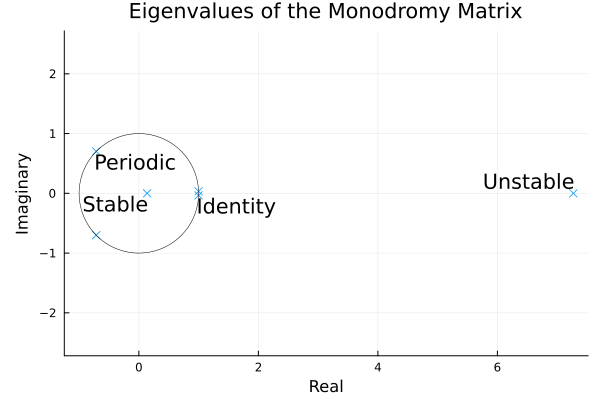

In [9]:
# Plot the eigenvalues on the complex plan
plot_eig = scatter(real(λ),imag(λ),legend=false,title="Eigenvalues of the Monodromy Matrix",xaxis="Real",yaxis="Imaginary",aspect_ratio=1,marker=:x);
plot!(plot_eig, circle(), seriestype = [:path,], lw = 0.5, linecolor = :black, label = "Unit Circle") # circle() is a function in ThreeBodyProblem.jl that produces the coordinates of the unit circle
annotate!(plot_eig, real(λ[1]), imag(λ[1]), text("Stable",:top, :right));
annotate!(plot_eig, real(λ[2]), imag(λ[2]), text("Unstable",:bottom, :right));
annotate!(plot_eig, real(λ[3]), imag(λ[3]), text("Identity",:top, :left));
annotate!(plot_eig, real(λ[6]), imag(λ[6]), text("Periodic",:top, :left))

You can see that there are two eigenvalues on the real axis. They are a reciprocal pair and correspond to stable and unstable motion. There is another pair very near to 1. Every purely periodic orbit has two eigenvalues that are 1, which correspond to motion along the periodic orbit itself. Any deviation from 1 is caused by numerical imprecision. The remaining two eigenvalues are complex conjugate pairs on the unit circle. They correspond to periodic motion around the halo orbit. These are the ones we will use to approximate the QPO.




## III-ii. Perturb our initial point
Because we sorted the eigenvalues by their imaginary magnitude, we should always be able to use the last one to find periodic motion.


In [10]:
eig_idx = 6 # Index of the eigenvalue we want to use

6

Note, sometimes, there are two pairs of eigenvalues on the unit circle. In that case, this method will use the one with the largest imaginary magnitude. If there are two pairs of eigenvalues on the unit circle, then the orbit is stable and there exist two periodic manifolds, so we could compute a 3-torus. But let's not worry about that for now.

We'll compute a ring of N points that are a small step α away from the initial condition and call those points u₀.

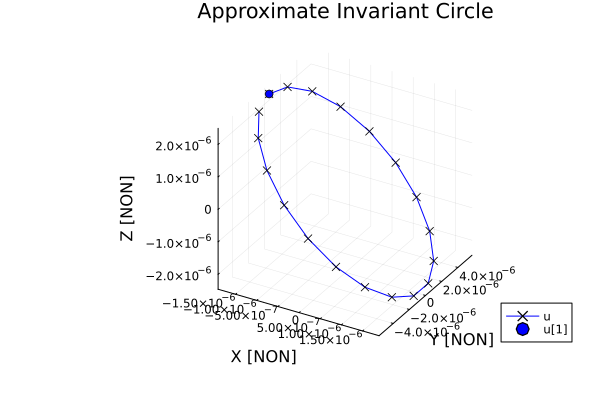

In [11]:
N = 19 # Number of points on the invariant circle (THIS SHOULD BE AN ODD NUMBER!!!)
# N is also the number of frequencies that we will break our u function into
n = 6 # Number of dimensions of the system

θ = 2π*(0:N-1)/N # Angles for the invariant circle
α = 1e-5 # parameter to control the size of the invariant circle
u = [α*(cos(θ[i])*real(V[:,eig_idx]) - sin(θ[i])*imag(V[:,eig_idx])) for i in 1:N] # Initial guess for the invariant circle
plot_u = plot(u, xlabel="X [NON]",ylabel="Y [NON]", zlabel= "Z [NON]", legend=true,label="u",title="Approximate Invariant Circle",linecolor=:blue, marker=:x); # Plot the invariant circle
scatter!(plot_u, [u[1][1]],[u[1][2]],[u[1][3]],label="u[1]",shape=:o,markercolor=:blue) # Plot an "x" on the first point of the invariant circle

### What is an invariant circle again?
An invariant circle is defined as a set of points that are mapped to themselves under the dynamics
So if this was the true invariant circle, then integrating this ring of points should return the exact same points
As an added point of subtlety, the points will have rotated by some angle ρ during that integration. This
ρ is referred to as the rotation number of the invariant circle.

## III-iii. Approximate rotation number
We'll use the periodic eigenvalue to guess the rotation number of the invariant circle

In [12]:
ρ = real(-im*log(λ[eig_idx])) # Initial guess (in radians) for the rotation number of the invariant circle

2.364783610709254

ρ is simply the angle of the eigenvalue in the complex plane. We'll use it later.

# IV. Perform Stroboscopic Mapping
The stroboscopic mapping integrates the invariant circle for one period and rotates it back by ρ radians. The resulting circle should match up with the initial circle (hence the "invariant" circle).


## IV-i. Integrate the invariant circle
In Julia, we can use the EnsembleProblem to solve the same problem N times with different initial conditions

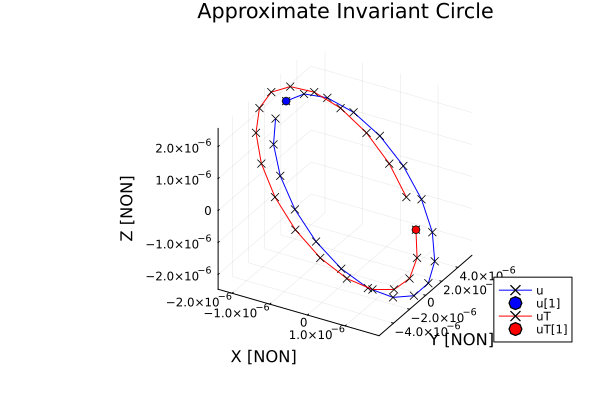

In [13]:
function prob_func(prob, i, repeat)
    remake(prob, u0=[rv₀+u[i]; reshape(Φ₀,36,1)]) # perturb rv₀ by the ith point of the invariant circle and use that as the initial condition
end # NOTE: Do not get confused! ODEProblems have an field called "u0" (e.g. prob_halo.u0) and the solved problems have a field called "u" (e.g. halo.u). Don't confuse these with the u₀ and u variables that we are defining here.
prob_qpo = EnsembleProblem(prob_halo, prob_func=prob_func) # ODE problem with an ensemble of trajectories. Note: we integrate it for T₀, the same period as the halo orbit, so we just use prob_halo
qpo = solve(prob_qpo, TsitPap8(), trajectories=N, abstol=1e-12, reltol=1e-12) # solve the problem

uT = [qpo[i].u[end][1:6]-rv₀ for i in 1:N] # Invariant circle after integrating (make sure to subtract the base point rv₀)
plot!(plot_u, uT, marker=:x,legend=true,label="uT",linecolor=:red); # Plot the invariant circle after integrating
scatter!(plot_u, [uT[1][1]],[uT[1][2]],[uT[1][3]],label="uT[1]",shape=:o,markercolor=:red); # Plot the first point of the integrated invariant circle
display(plot_u)

You can see that the invariant circle doesn't quite match the integrated invariant circle. You can also see the rotation number at work, as the first point of the integrated invariant circle is rotated by about ρ radians. Let's plot this in 2D to see the rotation number at work more clearly.


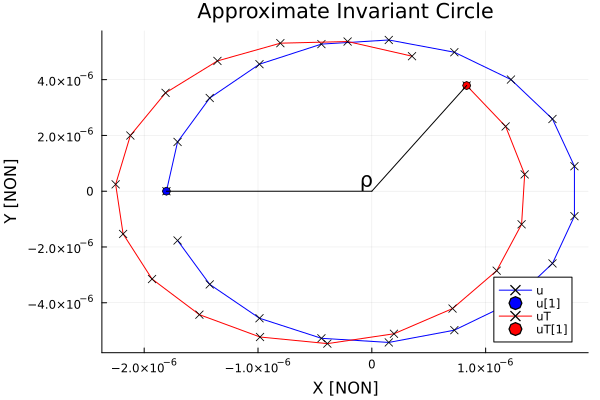

In [14]:
plot_u2D = plot(u, xlabel="X [NON]",ylabel="Y [NON]", planar=true, marker=:x, legend=true,label="u",title="Approximate Invariant Circle",linecolor=:blue); # Plot the invariant circle
scatter!(plot_u2D, [u[1][1]],[u[1][2]], label="u[1]",shape=:o,markercolor=:blue); # Plot a marker on the first point of the invariant circle
plot!(plot_u2D, uT, planar=true, legend=true,label="uT",linecolor=:red, marker=:x); # Plot the invariant circle after integrating
scatter!(plot_u2D, [uT[1][1]],[uT[1][2]], label="uT[1]",shape=:o,markercolor=:red); # Plot the first point of the integrated invariant circle
plot!(plot_u2D, [0,uT[1][1]], [0,uT[1][2]],linecolor=:black,label="");
plot!(plot_u2D, [0,u[1][1]], [0,u[1][2]],linecolor=:black,label="");
annotate!(plot_u2D, 0, 0, text("ρ",:bottom, :right))

This is called a stroboscopic map. It takes points x(t) and maps them to the points x(t+T). The stroboscopic map of a periodic orbit is a single point, because x(t) = x(t+nT). But for a quasi-periodic orbit, the stroboscopic map is topologically a circle. Therefore, our differential corrector will have to compare circles. If the initial circle and the integrated circle are the same, then the circle is "invariant" and we have found the quasi-periodic orbit

## IV-ii. Compare Circles
To truly compare the two circles, we need to rotate the integrated invariant circle back by ρ radians. We'll create a rotation operator R to do this. We can't just use an ordinary rotation matrix, as the invariant circle may be elliptical and lives in 6D phase space rather than 3D position space. Instead, we'll use the discrete Fourier transform the invariant circle in the Fourier domain, apply the rotation there, then transform it back to the real domain.

### Discrete Fourier Transform
D is the discrete Fourier transform matrix. When we left-multiply our invariant circle points with D we get a matrix of Fourier coefficients.

In [15]:
k = Int(-(N-1)/2):Int((N-1)/2); # Vector of integers from -(N-1)/2 to (N-1)/2. N is odd, so (N-1)/2 is an integer.
D = 1/N*exp.(-im*k*θ'); # make sure to use exp.() rather than exp() to perform elementwise exponentiation.

We are applying the exponential operator to each component rather than performing the matrix exponential. D is a constant matrix, as k and θ won't change. The D matrix is size NxN, so we would like to choose as small of an N as possible. Let's look at what the D matrix does to the invariant circle.

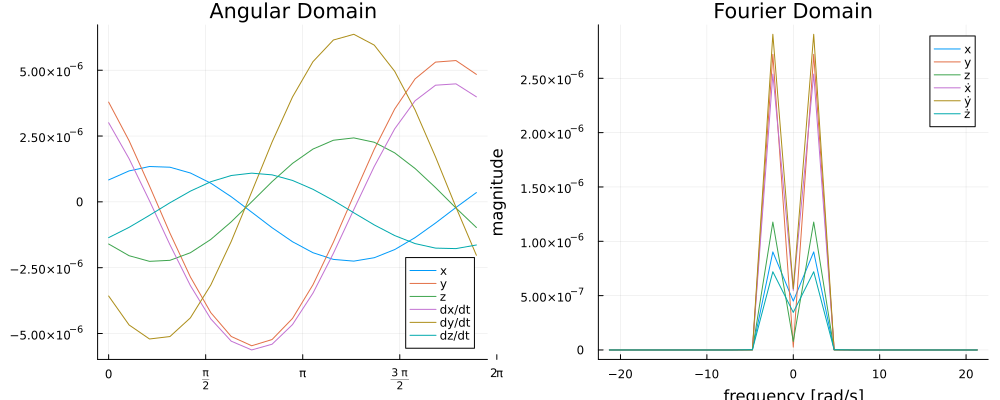

In [16]:
UT = reduce(vcat,uT') # UT is an Nx6 matrix form of uT
pθ = plot(θ, UT, xticks = ([0:π/2:2*π;], ["0","\\pi/2","\\pi","3 \\pi/2","2\\pi"]),xlabel="θ [rad]",ylabel="",legend=true,title="Angular Domain",label=["x" "y" "z" "dx/dt" "dy/dt" "dz/dt"]); # Plot the result
uT_fourier = D*UT # uT_fourier is the invariant circle in the Fourier domain
pf = plot(k*ρ, abs.(uT_fourier),xlabel="frequency [rad/s]",ylabel="magnitude",legend=true,title="Fourier Domain",label=["x" "y" "z" "ẋ" "ẏ" "ż"]); # Plot the result
plot_fourier = plot(pθ,pf,layout=(1,2),size=(1000,400)) # Plot the two plots side by side

### Rotation Operator
Now that we have our invariant circle converted to the Fourier domain, let's rotate it backwards by ρ radians. Note, we need to rotate it backwards becasuse ρ is the amount it has rotated forward through integration. We need to reverse this rotation.

Recall that multiplying by eⁱˣ rotates a number by x radians in the complex plane. We can use this fact to create Q(ρ), which rotates every point backward by kᵢρ radians (or forward by -kᵢρ radians).

In [17]:
Q(ρ) = Diagonal(exp.(-im*k*ρ)) # Q is the rotation operator in the fourier domain. It's a diagonal matrix made up of exponential terms

Q (generic function with 1 method)

We now complete the following steps 
1. Multiply by D to enter the Fourier domain
2. Multiply by Q(ρ) to rotate backwards by ρ radians
3. Multiply by D⁻¹ to exit the Fourier domain back into the real domain
4. Constrain the result to be purely real (to get rid of any straggling imaginary parts from numerical imprecision)

We'll put this all into our big rotation operator R(ρ), which is the rotation operator in the real domain.

In [18]:
R(ρ) = real(inv(D)*Q(ρ)*D) #  We use the similarity transform to convert it to the real domain.

R (generic function with 1 method)

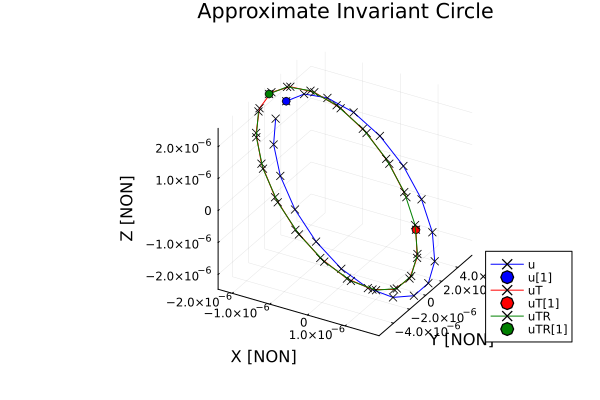

In [19]:
UTR = R(ρ)*UT # Rotate the integrated invariant circle back by ρ₀ radians
uTR = [UTR[i,:] for i in 1:N] # Convert back to a vector of vectors
# uTR is the integrated invariant circle rotated back by ρ radians
# So we should be able to compare u₀ with uTR. If they are the same, then we have found the quasi-periodic orbit
plot!(plot_u, uTR,legend=true,label="uTR",linecolor=:green,marker=:x); # Plot the invariant circle after integrating and rotating
scatter!(plot_u, [uTR[1][1]],[uTR[1][2]],[uTR[1][3]],label="uTR[1]",shape=:o,markercolor=:green) # Plot the first point of the rotated, integrated invariant circle
display(plot_u)

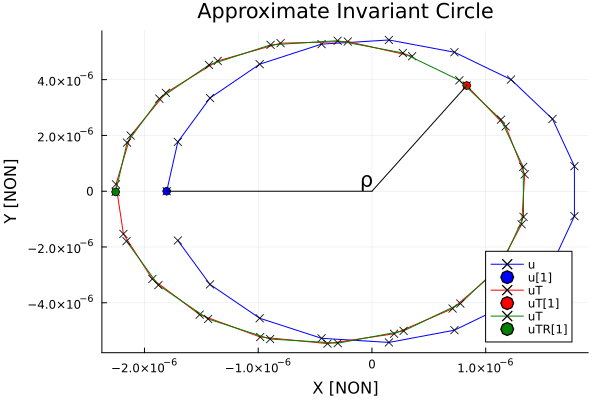

In [20]:
plot!(plot_u2D, uTR, planar=true, legend=true,label="uT",linecolor=:green, marker=:x); # Plot the invariant circle after integrating and rotating
scatter!(plot_u2D, [uTR[1][1]],[uTR[1][2]], label="uTR[1]",shape=:o,markercolor=:green) # Plot the first point of the integrated/rotated invariant circle

We can see that the rotation operator has done its job, as the first point of the integrated invariant circle is now rotated back to the same angle as the first point of the initial invariant circle.

## IV-iii.  Compute Error
We define the error term u_err as the difference between the initial and integrated/rotated invariant circles. If the norm of the error is above a certain threshold, we'll have to do some differential correction

In [21]:
u_err = uTR - u # Compute the error between the initial and integrated/rotated invariant circles
err = norm(u_err) # size of the error

4.2383424751616865e-6

That error is small but not small enough. We can see that the invariant circles don't line up perfectly yet. We started with a small perturbation α. If we increase α, the error will increase.

In [22]:
ϵ = α/10 # Set the threshold for the error to be 1/10 of α

1.0000000000000002e-6

# V. Differential Correction
Now we're going to do some differential correction to refine the invariant circle and reduce the error. We should repeat this step until err < ϵ.

### Differential Correction Review

As a quick review, let's imagine we have some nonlinear function $y=f(x)$. Let's say we want to find the $x^*$ such that $f(x^*) = y^*$. Let's also say that we have a good guess $x_0 \approx x^*$, where $y_0 = f(x_0)$. Since $x_0$ is close to $x^*$, then there exists some small $dx$ such that $x_0 + dx = x^*$. This means that $f(x_0 + dx) = f(x^*) = y^*$. If we take the taylor expansion of $f(x)$ we get

$$f(x + dx) = f(x) + \frac{\partial f}{\partial x} dx + O(dx^2)$$

Let's assume dx is small, so we can ignore the second order terms $O(dx^2)$. This leaves

$$ f(x_0 + dx) = f(x_0) + \frac{\partial f}{\partial x} dx $$

Recall that $f(x_0 + dx) = y^*$, so let's rewrite this as
$$ y^* = y_0 + \frac{\partial f}{\partial x} dx $$

Let's say $dy = y^* - y_0$ is our error. Then we have

$$ dx = \frac{\partial f}{\partial x}^{-1}dy$$

We have an equation for the difference between our initial guess and the true value that we want. This is generalizable to vectors
$$ d\vec{x} = J^{-1}d\vec{y}$$
where $J = \frac{\partial \vec{y}}{\partial \vec{x}}$ is our Jacobian matrix.

So, if we can create a Jacobian matrix $J$ and an error vector $d\vec{y}$, then we can compute the change $d\vec{x}$ to our initial condition that will minimize the error.

## V-i. Construct the Error Vector
<!-- We'll call our error vector $\vec{\gamma}$ just so we don't get mixed up between the y-coordinates.  -->
We will construct the error vector as a large column vector made up of the vector differences between each point along uTR and u. We'll also add the difference between the average Jacobi constant of uTR and the Jacobi constant of the underlying periodic orbit. Whatever we put into the error vector should approach zero after enough iterations, so we are constraining our final QPO to have the same jacobi constant as the underlying halo orbit.
$$ d\vec{y} = \begin{bmatrix}\vec{u}^{t,R}_1 - \vec{u}_{1} \\ \vdots \\ \vec{u}^{t,R}_N - \vec{u}_{N} \\ C_{u} - C_0\end{bmatrix}$$

$C_{u}$ is just the average Jacobi constant of the set $\mathcal{u}$.
$$ C_{u} = \frac{1}{N}\sum_{i=1}^N C(\vec{u}_i) $$

In [23]:
Cᵤ = sum([computeC(rv₀+u[i],sys) for i in 1:N])/N # Compute the average Jacobi constant across the invariant circle
dy = [reduce(vcat,u_err); # reduce(vcat,u_err) turns u_err into one big long vector instead of a vector of vectors 
               Cᵤ - C₀];

### How much does the Jacobi constant vary?
Let's take a look at the Jacobi constant of the invariant circle

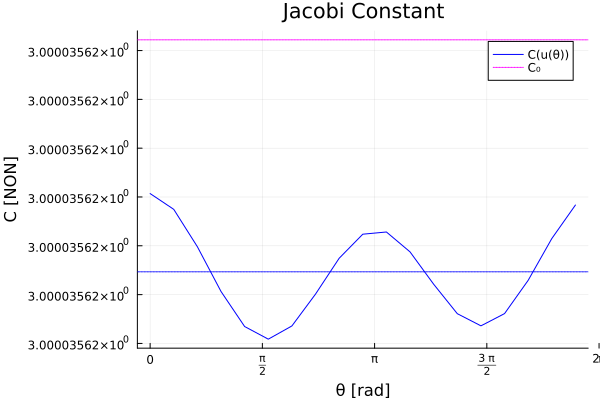

GKS: Possible loss of precision in routine SET_WINDOW


In [24]:
plot_C = plot(θ, [computeC(rv₀+u[i],sys) for i in 1:N], xticks = ([0:π/2:2*π;], ["0","\\pi/2","\\pi","3 \\pi/2","2\\pi"]), xlabel="θ [rad]",ylabel="C [NON]", legend=true, title="Jacobi Constant", label="C(u(θ))", color=:blue)
hline!(plot_C, [C₀], label="C₀", linestyle=:dot, color=:magenta) # horizontal line for halo orbit Jacobi constant C₀
hline!(plot_C, [Cᵤ], label="", linestyle=:dot, color=:blue) # horizontal line for average Jacobi constant Cᵤ of u

## V-ii. Construct the Initial Condition Vector
We don't need the initial condition vector to do our calculation, but it is good to have it written out for clarity when constructing the Jacobian. 
<!-- We'll call our initial condition vector $\vec{\xi}$ so we don't get mixed up with the x-coordinates. -->
Our vector should be made up of things that we can change in order to make our stroboscopic mapping match up perfectly. Therefore, it should be made up of u as well as the rotation number ρ and the period T
$$ \vec{x} = \begin{bmatrix} \vec{u}_1 \\ \vdots \\ \vec{u}_{N} \\ T \\ \rho \end{bmatrix},$$

meaning $d\vec{x}$ will be a vector of small changes to these values.

## V-iii. Construct the Jacobian Matrix
The Jacobian matrix $J = \frac{\partial \vec{y}}{\partial \vec{x}}$ can be written out as block components
$$ J = \begin{bmatrix} \frac{\partial (u^{t,R} - u)}{\partial u} & \frac{\partial (u^{t,R} - u)}{\partial T} & \frac{\partial (u^{t,R} - u)}{\partial \rho} \\ \frac{\partial (C_u - C_0)}{\partial u} & \frac{\partial (C_u - C_0)}{\partial T} & \frac{\partial (C_u - C_0)}{\partial \rho} \end{bmatrix} $$

Luckily, a lot of these terms are zero: $ \frac{\partial u}{\partial T}, \frac{\partial u}{\partial \rho}, \frac{\partial C_u}{\partial T}, \frac{\partial C_u}{\partial \rho}, \frac{\partial C_0}{\partial u}, \frac{\partial C_0}{\partial T}, \frac{\partial C_0}{\partial \rho} = 0$. Also, it is clear that $\frac{\partial u}{\partial u} = I$ so we can simplify our expression to
$$ J = \begin{bmatrix} \frac{\partial u^{t,R}}{\partial u} - I & \frac{\partial u^{t,R}}{\partial T} & \frac{\partial u^{t,R}}{\partial \rho} \\ \frac{\partial C_u}{\partial u} & 0 & 0 \end{bmatrix} = \begin{bmatrix} J_1 & J_2 & J_3 \\ J_4 & 0 & 0\end{bmatrix} $$

We'll write out each of these terms, but we won't necessarily go through the entire derivation for each one.

$$ \frac{\partial u^{t,R}}{\partial u} = \left(R(-\rho) \otimes I_6 \right)\tilde{\Phi}\\
\tilde{\Phi} = \begin{bmatrix} \Phi_1(T, 0) & 0 & \cdots & 0\\
0 & \Phi_2(T, 0) & \cdots & 0 \\
\vdots & \vdots & \ddots & \vdots\\
0 & 0 & \cdots & \Phi_N(T, 0)\end{bmatrix}$$

$$ \frac{\partial u^{t,R}}{\partial T} = \begin{bmatrix} \dot{\vec{u}}^{t,R}_1 \\ \vdots \\ \dot{\vec{u}}^{t,R}_N \end{bmatrix}$$

$$ \frac{\partial u^{t,R}}{\partial \rho} = D^{-1} \frac{\partial Q}{\partial \rho} D U^t$$


$$ \frac{\partial C_u}{\partial u} = \frac{1}{N}\begin{bmatrix} \begin{bmatrix} 2\Omega_{x,1} \\ 2\Omega_{y,1} \\ 2\Omega_{z,1} \\ -2\dot{x}_1 \\ -2\dot{y}_1 \\ -2\dot{z}_1 \end{bmatrix}^\intercal \dots \begin{bmatrix} 2\Omega_{x,N} \\ 2\Omega_{y,N} \\ 2\Omega_{z,N} \\ -2\dot{x}_N \\ -2\dot{y}_N \\ -2\dot{z}_N \end{bmatrix}^\intercal \end{bmatrix} $$

### $J₁ = \frac{\partial u^{t,R}}{\partial u} - I$

In [25]:
Φ_tilde = zeros(6N,6N);
for i = 1:N
    idx = (i-1)*n + 1:i*n;
    Φ_tilde[idx,idx] = reshape(qpo[i].u[end][7:end],6,6); # Φ_tilde is made up of the state transition matrices of each point of the invariant circle (unrotated points, as the rotation operator doesn't depend on u and gets multiplied later)
end
∂uTR_∂u = kron(R(ρ),I(6))*Φ_tilde; # Compute the derivative of the integrated/rotated invariant circle with respect to the initial invariant circle (u₀) 
J₁ = ∂uTR_∂u - I(6N); # We subtract the identity because we want ∂(uTR-u)/∂u

### $J₂ = \frac{\partial u^{t,R}}{\partial T}$

In [26]:
J₂ = zeros(6N,1) # column vector of size 6N
for i = 1:N
    idx = (i-1)*n + 1:i*n
    ẋ, ẏ, ż, ẍ, ÿ, z̈ = CR3BPdynamics(rv₀ + uTR[i],sys,0) # don't forget to add rv₀ to uTR[i]
    J₂[idx] = [ẋ, ẏ, ż, ẍ, ÿ, z̈] # The derivative with respect to time comes right from the equations of motion
end

### $J₃ = \frac{\partial u^{t,R}}{\partial \rho}$

In [27]:
∂Q_∂ρ(ρ) = Diagonal(-im*k.*exp.(-im*k*ρ)); # Compute the derivative of the rotation operator in the Fourier domain
 J₃ = real(inv(D)*∂Q_∂ρ(ρ)*D)*UT; # Compute the derivative of the rotation operator in the real domain
 J₃ = reshape(J₃',6N,1); # Convert to a column vector

### $J₄ = \frac{\partial C}{\partial u}$

In [28]:
J₄ = zeros(1,6N)
for i = 1:N
    idx = (i-1)*n + 1:i*n
    ẋ, ẏ, ż, ẍ, ÿ, z̈ = CR3BPdynamics(rv₀ + u[i],sys,0) # Note, I'm using u instead of uTR here.
    Ωx = ẍ - 2ẏ
    Ωy = ÿ + 2ẋ
    Ωz = z̈
    J₄[idx] = [2Ωx, 2Ωy, 2Ωz, -2ẋ, -2ẏ, -2ż]./N # Don't forget to divide by N because Cᵤ is an average of every C(uᵢ)
end    

### The full Jacobian

In [29]:
J = [J₁  J₂  J₃; # block matrix notation is easy in Julia
     J₄   0   0];

## V-ii. Compute Optimal Change in Initial Conditions

In [30]:
dx = J\dy; # the backward slash is the left division operator. It is similar to J⁻¹dy but works even for non-invertible matrices.

# Take out each component
du = [dx[(i-1)*n + 1:i*n] for i = 1:N];
dT = dx[6N+1];
dρ = dx[6N+2];

### Before we apply du, dρ, and dT, let's make sure we save our initial conditions for later

In [31]:
u₀ = u
T = T₀ # T₀ is defined as the period of the halo orbit. We expect that T will vary slightly from T₀
ρ₀ = ρ

# Update guesses for u, ρ, and T
u = u + du;
T = T + dT;
ρ = ρ + dρ;

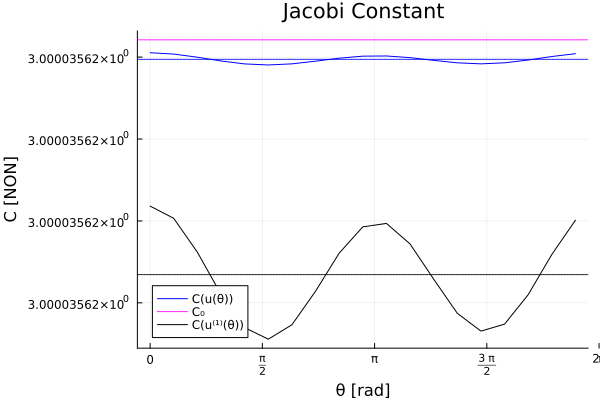

In [32]:
Cᵤ = sum([computeC(rv₀+u[i],sys) for i in 1:N])/N

# Add new guess for u to the Jacobi constant plot
plot!(plot_C, θ, [computeC(rv₀+u[i],sys) for i in 1:N], xticks = ([0:π/2:2*π;], ["0","\\pi/2","\\pi","3 \\pi/2","2\\pi"]), xlabel="θ [rad]",ylabel="C [NON]", legend=true, title="Jacobi Constant", label="C(u⁽¹⁾(θ))", color=:black)
hline!(plot_C, [Cᵤ], label="", linestyle=:dot, color=:black) # horizontal line for average Jacobi constant Cᵤ of u!

<!-- We can see that the Jacobi constant of the next guess is much farther to the desired Jacobi constant of the Halo orbit. -->

### What does the new guess look like?

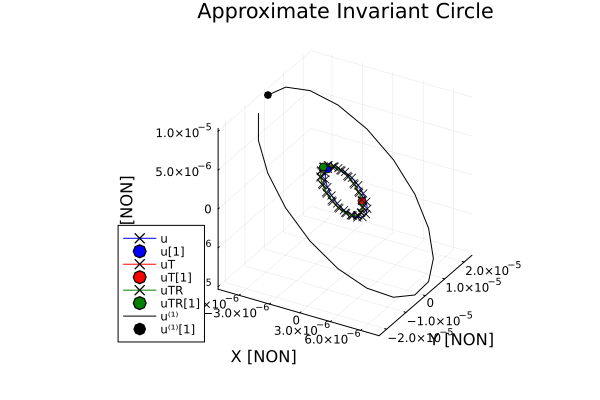

In [33]:
plot!(plot_u, u,legend=true,label="u⁽¹⁾",linecolor=:black); # Plot the invariant circle after integrating
scatter!(plot_u, [u[1][1]],[u[1][2]],[u[1][3]],label="u⁽¹⁾[1]",shape=:o,markercolor=:black); # Plot the first point of the integrated invariant circle
display(plot_u)

Our optimizer expanded our initial guess significantly.

In [34]:
u, ρ, T, C, uᵢ = differential_corrector_QPO(sys,rv₀,u₀,ρ₀,T₀,max_iter = 10);

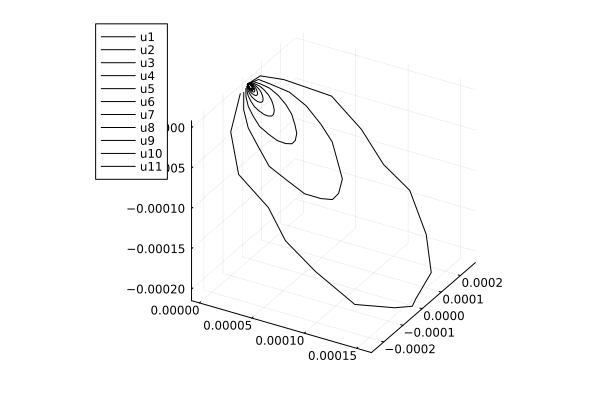

In [35]:
plot_uᵢ = plot();
for i = 1:length(uᵢ)
    plot!(uᵢ[i],label=string("u",i));
end
plot_uᵢ

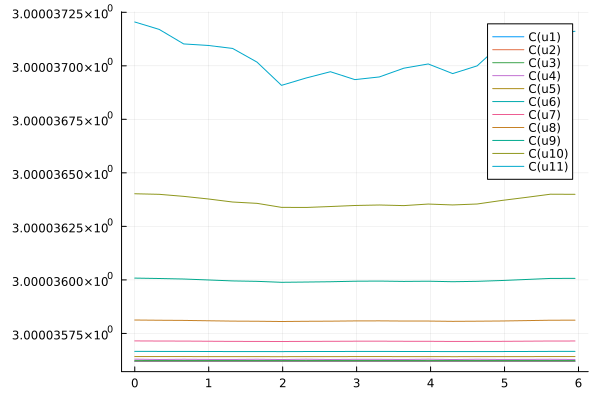

In [36]:
plot_Cᵢ = plot();
for i = 1:length(uᵢ)
    plot!(θ,[computeC(rv₀+uᵢ[i][j],sys) for j in 1:N],label=string("C(u",i,")"));
end
plot_Cᵢ